In [2]:
import numpy as np
import pickle
from tqdm import tqdm

# all activity labels
# activity_labels = ['Walking', 'Running', 'GoingUpS', 'GoingDownS', 'Jumping', 'SittingDown', 'StandingUpFS', 'LyingDownFS', 'StandingUpFL', 'FallingForw', 'FallingBack', 'FallingRight', 'FallingLeft', 'Syncope', 'FallingBackSC', 'FallingWithPS', 'HittingObstacle']

# we only care about these 9 activity labels (codem paper)
activity_labels = ['Walking', 'Running', 'GoingUpS', 'GoingDownS', 'Jumping', 'SittingDown', 'StandingUpFS', 'LyingDownFS', 'StandingUpFL']
train_subjects = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]  # all subjects
val_subjects   = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]  # all subjects

# train_subjects = [1, 6, 8, 0, 2, 3, 4, 5, 7, 9, 10, 11, 12, 14, 15]
# val_subjects = [13, 25, 29, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28]

# train_folds = [0, 1, 2, 3, 4, 5] # all folds
train_folds = [0]
val_folds = [1]

# label_cols = ['activity', 'subject', 'weight', 'height', 'age', 'gender', 'fold', 'position'] # all cols
label_col = 'activity'
data_cols = ['x', 'y', 'z']

train_data, train_target = [], []
val_data, val_target = [], []
with open('/workspace/postdoc/imu_datasets/UniMiB-SHAR/window_len=90+offset=45+fraction_per_trial=1.0/windows.pkl', 'rb') as f:
    windows = pickle.load(f)
    for window in tqdm(windows, desc='Collecting samples'):
        assert len(window[label_col].unique()) == 1  # make sure all samples in a window have the same label

        if window.loc[0, 'activity'] in activity_labels and window.loc[0, 'fold'] in train_folds and window.loc[0, 'subject'] in train_subjects:
            train_data.append(window[data_cols].values)
            train_target.append(window.loc[0, label_col])

        if window.loc[0, 'activity'] in activity_labels and window.loc[0, 'fold'] in val_folds and window.loc[0, 'subject'] in val_subjects:
            val_data.append(window[data_cols].values)
            val_target.append(window.loc[0, label_col])
train_data = np.stack(train_data, axis=0).astype(np.float32)
val_data = np.stack(val_data, axis=0).astype(np.float32)
# target = pd.DataFrame(target)

In [3]:
len(train_data), len(val_data)

(2750, 2699)

In [4]:
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder


class HARDataset(Dataset):
    def __init__(self, data: np.ndarray, 
                 target: np.ndarray, 
                 mean: np.ndarray = None, 
                 std: np.ndarray = None,
                 lencoder: LabelEncoder = None
                 ):
        super(HARDataset, self).__init__()
        
        # normalize the data
        if mean is None and std is None:
            print('Calculating mean and std')
            self.mean = data.mean((0, 1)) if mean is None else mean
            print('mean:', self.mean)
            self.std = data.std((0, 1)) if std is None else std
            print('std:', self.std)
        else:
            print('Using the provided mean and std')
            self.mean = mean
            self.std = std
        self.data = (data - self.mean) / (self.std + 1e-12)
        
        # encode the target
        self.target = target
        if lencoder is None:
            print('Creating a new label encoder')
            self.lenconder = LabelEncoder()
            self.target_encoded = self.lenconder.fit_transform(target)
            print('Class mapping:')
            for i, class_ in enumerate(self.lenconder.classes_):
                print(f'{class_} -> {i}')
        else:
            print('Using the provided label encoder')
            self.lenconder = lencoder
            self.target_encoded = self.lenconder.transform(target)

    def __getitem__(self, index: int):
        return self.data[index], self.target_encoded[index]

    def __len__(self):
        return self.data.shape[0]


train_dataset = HARDataset(train_data, train_target)
val_dataset = HARDataset(val_data, val_target, lencoder=train_dataset.lenconder, mean=train_dataset.mean, std=train_dataset.std)

Calculating mean and std
mean: [-0.00229858 -0.00068774  0.00268041]
std: [2.5681877 3.9329655 2.5103943]
Creating a new label encoder
Class mapping:
GoingDownS -> 0
GoingUpS -> 1
Jumping -> 2
LyingDownFS -> 3
Running -> 4
SittingDown -> 5
StandingUpFL -> 6
StandingUpFS -> 7
Walking -> 8
Using the provided mean and std
Using the provided label encoder


<AxesSubplot:title={'center':'Train dataset class distribution'}>

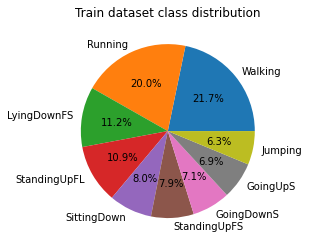

In [5]:
# update the code show the percentage of each class in the dataset
pd.Series(train_dataset.lenconder.inverse_transform([target for _, target in train_dataset])).value_counts().plot(kind='pie', title='Train dataset class distribution', ylabel='', autopct='%1.1f%%')


<AxesSubplot:title={'center':'Val dataset class distribution'}>

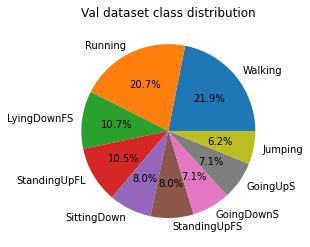

In [6]:
pd.Series(val_dataset.lenconder.inverse_transform([target for _, target in val_dataset])).value_counts().plot(kind='pie', title='Val dataset class distribution', ylabel='', autopct='%1.1f%%')

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=1)
val_loader   = DataLoader(val_dataset,   batch_size=256, shuffle=True, num_workers=1)

In [44]:
import torch.nn as nn

from dataclasses import dataclass

@dataclass
class HyperParams:
    dropout: float = 0.1
    channels: int = 3
    k: list = (128, 128, 128)
    ks: list = (9, 9, 9)
    linears: list = (64, 64)
    classes: int = 9


class DepthwiseSeparableConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=(1, 1), padding='valid'):
        super(DepthwiseSeparableConv2D, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, groups=in_channels, bias=False,
                      padding=padding),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)

class HappFeetDepthwiseSeperable(nn.Module):
    def __init__(self, h: HyperParams):
        super().__init__()
        self.convnet = nn.Sequential(
            nn.Dropout(h.dropout),
            # DepthwiseSeparableConv2D(h.channels, h.k[0], kernel_size=(h.ks[0], 1)),
            nn.Conv2d(h.channels, h.k[0], kernel_size=(h.ks[0], 1)),
            nn.BatchNorm2d(h.k[0]),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1)),

            nn.Dropout(h.dropout),
            DepthwiseSeparableConv2D(h.k[0], h.k[1], kernel_size=(h.ks[1], 1)),
            nn.MaxPool2d(kernel_size=(2, 1)),

            nn.Dropout(h.dropout),
            DepthwiseSeparableConv2D(h.k[1], h.k[2], kernel_size=(h.ks[2], 1)),
            nn.MaxPool2d(kernel_size=(2, 1)),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),

            nn.Dropout(h.dropout),
            nn.Linear(h.k[2], h.linears[0]),
            nn.BatchNorm1d(h.linears[0]),
            nn.ReLU(inplace=True),
            
            nn.Dropout(h.dropout),
            nn.Linear(h.linears[0], h.linears[1]),
            nn.BatchNorm1d(h.linears[1]),
            nn.ReLU(inplace=True),
        )
        self.clf = nn.Sequential(
            nn.Dropout(h.dropout),
            nn.Linear(h.linears[1], h.classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x, **kwargs): # (batch, window, channel)
        x = x.unsqueeze(1).permute(0, 3, 2, 1) # (batch, 1, window, channel) -> (batch, channel, window, 1)
        features = self.convnet(x)
        out = self.clf(features)
        return out


In [45]:
h = HyperParams(classes=len(activity_labels), k=[128, 128, 128], ks=[9, 9, 9], linears=[64, 64], dropout=0.1) # NOTE: play with the dropout rate
h

HyperParams(dropout=0.2, channels=3, k=[128, 128, 128], ks=[9, 9, 9], linears=[64, 64], classes=9)

In [46]:
def num_params(model):
    return sum([p.numel() for p in model.parameters() if p.requires_grad])

net = HappFeetDepthwiseSeperable(h)
print(f"Total number of parameters: {num_params(net) / 1e3}k")
net

Total number of parameters: 53.193k


HappFeetDepthwiseSeperable(
  (convnet): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(3, 128, kernel_size=(9, 1), stride=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
    (6): DepthwiseSeparableConv2D(
      (net): Sequential(
        (0): Conv2d(128, 128, kernel_size=(9, 1), stride=(1, 1), padding=valid, groups=128, bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (7): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=Fals

In [47]:
import torch
import torch.nn.functional as F

optim = torch.optim.AdamW(net.parameters(), lr=1e-3, weight_decay=1e-3)

device = torch.device("cuda:0")
# device = torch.device("cpu")
net.to(device)
for epoch in range(100):
    net.train()
    ground_truths = []
    preds = []
    with tqdm(train_loader, desc=f"Training epoch   {epoch}") as train_bar:
        for train_batch in train_bar:
            optim.zero_grad()
            sample, target = train_batch[0].to(device), train_batch[1].to(device)
            ground_truths.append(target)
            pred = net(sample)
            preds.append(pred)
            loss = F.nll_loss(pred, target)
            train_bar.update()
            train_bar.set_postfix(loss=loss.item())
            loss.backward()
            optim.step()
    ground_truths = torch.cat(ground_truths)
    preds = torch.cat(preds)
    acc = (ground_truths == preds.argmax(dim=1)).float().mean()
    print(f"Training accuracy:  {acc.item() * 100:.2f}%")

    # evaluation
    net.eval()
    ground_truths = []
    preds = []
    with tqdm(val_loader, desc=f"Validating epoch {epoch}") as val_bar:
        for val_batch in val_bar:
            sample, target = val_batch[0].to(device), val_batch[1].to(device)
            ground_truths.append(target)
            with torch.no_grad():
                pred = net(sample)
            preds.append(pred)
            val_bar.update()
    ground_truths = torch.cat(ground_truths)
    preds = torch.cat(preds)
    acc = (ground_truths == preds.argmax(dim=1)).float().mean()
    print(f"Validation accuracy: {acc.item() * 100:.2f}%")
    print('-' * 80)

Training epoch   0:   0%|          | 0/11 [00:00<?, ?it/s]

Training epoch   0: 100%|██████████| 11/11 [00:00<00:00, 17.91it/s, loss=1.83]


Training accuracy:  28.87%


Validating epoch 0: 100%|██████████| 11/11 [00:00<00:00, 25.25it/s]


Validation accuracy: 21.90%
--------------------------------------------------------------------------------


Training epoch   1: 100%|██████████| 11/11 [00:00<00:00, 19.01it/s, loss=1.67]


Training accuracy:  42.51%


Validating epoch 1: 100%|██████████| 11/11 [00:00<00:00, 21.13it/s]


Validation accuracy: 23.93%
--------------------------------------------------------------------------------


Training epoch   2: 100%|██████████| 11/11 [00:00<00:00, 18.49it/s, loss=1.42]


Training accuracy:  46.76%


Validating epoch 2: 100%|██████████| 11/11 [00:00<00:00, 20.45it/s]


Validation accuracy: 35.57%
--------------------------------------------------------------------------------


Training epoch   3: 100%|██████████| 11/11 [00:00<00:00, 19.23it/s, loss=1.3] 


Training accuracy:  51.02%


Validating epoch 3: 100%|██████████| 11/11 [00:00<00:00, 21.52it/s]


Validation accuracy: 47.54%
--------------------------------------------------------------------------------


Training epoch   4: 100%|██████████| 11/11 [00:00<00:00, 18.77it/s, loss=1.19]


Training accuracy:  53.53%


Validating epoch 4: 100%|██████████| 11/11 [00:00<00:00, 21.60it/s]


Validation accuracy: 49.69%
--------------------------------------------------------------------------------


Training epoch   5: 100%|██████████| 11/11 [00:00<00:00, 18.51it/s, loss=1.19]


Training accuracy:  55.49%


Validating epoch 5: 100%|██████████| 11/11 [00:00<00:00, 25.79it/s]


Validation accuracy: 51.72%
--------------------------------------------------------------------------------


Training epoch   6: 100%|██████████| 11/11 [00:00<00:00, 18.73it/s, loss=1.07]


Training accuracy:  58.29%


Validating epoch 6: 100%|██████████| 11/11 [00:00<00:00, 20.72it/s]


Validation accuracy: 53.83%
--------------------------------------------------------------------------------


Training epoch   7: 100%|██████████| 11/11 [00:00<00:00, 18.92it/s, loss=1.07]


Training accuracy:  60.36%


Validating epoch 7: 100%|██████████| 11/11 [00:00<00:00, 21.24it/s]


Validation accuracy: 56.95%
--------------------------------------------------------------------------------


Training epoch   8: 100%|██████████| 11/11 [00:00<00:00, 18.74it/s, loss=0.993]


Training accuracy:  62.98%


Validating epoch 8: 100%|██████████| 11/11 [00:00<00:00, 20.63it/s]


Validation accuracy: 58.47%
--------------------------------------------------------------------------------


Training epoch   9: 100%|██████████| 11/11 [00:00<00:00, 18.70it/s, loss=0.837]


Training accuracy:  65.67%


Validating epoch 9: 100%|██████████| 11/11 [00:00<00:00, 23.08it/s]


Validation accuracy: 58.54%
--------------------------------------------------------------------------------


Training epoch   10: 100%|██████████| 11/11 [00:00<00:00, 18.20it/s, loss=0.866]


Training accuracy:  67.82%


Validating epoch 10: 100%|██████████| 11/11 [00:00<00:00, 25.54it/s]


Validation accuracy: 62.06%
--------------------------------------------------------------------------------


Training epoch   11: 100%|██████████| 11/11 [00:00<00:00, 18.74it/s, loss=0.768]


Training accuracy:  69.45%


Validating epoch 11: 100%|██████████| 11/11 [00:00<00:00, 23.99it/s]


Validation accuracy: 62.95%
--------------------------------------------------------------------------------


Training epoch   12: 100%|██████████| 11/11 [00:00<00:00, 18.94it/s, loss=0.799]


Training accuracy:  70.58%


Validating epoch 12: 100%|██████████| 11/11 [00:00<00:00, 20.15it/s]


Validation accuracy: 63.65%
--------------------------------------------------------------------------------


Training epoch   13: 100%|██████████| 11/11 [00:00<00:00, 18.62it/s, loss=0.712]


Training accuracy:  73.64%


Validating epoch 13: 100%|██████████| 11/11 [00:00<00:00, 20.83it/s]


Validation accuracy: 65.36%
--------------------------------------------------------------------------------


Training epoch   14: 100%|██████████| 11/11 [00:00<00:00, 18.54it/s, loss=0.681]


Training accuracy:  73.20%


Validating epoch 14: 100%|██████████| 11/11 [00:00<00:00, 25.32it/s]


Validation accuracy: 65.62%
--------------------------------------------------------------------------------


Training epoch   15: 100%|██████████| 11/11 [00:00<00:00, 18.44it/s, loss=0.643]


Training accuracy:  74.76%


Validating epoch 15: 100%|██████████| 11/11 [00:00<00:00, 25.77it/s]


Validation accuracy: 65.95%
--------------------------------------------------------------------------------


Training epoch   16: 100%|██████████| 11/11 [00:00<00:00, 19.56it/s, loss=0.659]


Training accuracy:  73.42%


Validating epoch 16: 100%|██████████| 11/11 [00:00<00:00, 21.55it/s]


Validation accuracy: 66.39%
--------------------------------------------------------------------------------


Training epoch   17: 100%|██████████| 11/11 [00:00<00:00, 18.89it/s, loss=0.585]


Training accuracy:  75.31%


Validating epoch 17: 100%|██████████| 11/11 [00:00<00:00, 20.91it/s]


Validation accuracy: 67.36%
--------------------------------------------------------------------------------


Training epoch   18: 100%|██████████| 11/11 [00:00<00:00, 18.90it/s, loss=0.586]


Training accuracy:  77.31%


Validating epoch 18: 100%|██████████| 11/11 [00:00<00:00, 24.54it/s]


Validation accuracy: 67.32%
--------------------------------------------------------------------------------


Training epoch   19: 100%|██████████| 11/11 [00:00<00:00, 22.01it/s, loss=0.576]


Training accuracy:  77.64%


Validating epoch 19: 100%|██████████| 11/11 [00:00<00:00, 26.08it/s]


Validation accuracy: 67.25%
--------------------------------------------------------------------------------


Training epoch   20: 100%|██████████| 11/11 [00:00<00:00, 18.44it/s, loss=0.546]


Training accuracy:  77.78%


Validating epoch 20: 100%|██████████| 11/11 [00:00<00:00, 21.38it/s]


Validation accuracy: 68.69%
--------------------------------------------------------------------------------


Training epoch   21: 100%|██████████| 11/11 [00:00<00:00, 18.93it/s, loss=0.585]


Training accuracy:  77.85%


Validating epoch 21: 100%|██████████| 11/11 [00:00<00:00, 21.76it/s]


Validation accuracy: 68.66%
--------------------------------------------------------------------------------


Training epoch   22: 100%|██████████| 11/11 [00:00<00:00, 19.08it/s, loss=0.565]


Training accuracy:  79.67%


Validating epoch 22: 100%|██████████| 11/11 [00:00<00:00, 20.82it/s]


Validation accuracy: 68.80%
--------------------------------------------------------------------------------


Training epoch   23: 100%|██████████| 11/11 [00:00<00:00, 18.86it/s, loss=0.48] 


Training accuracy:  80.47%


Validating epoch 23: 100%|██████████| 11/11 [00:00<00:00, 20.69it/s]


Validation accuracy: 67.28%
--------------------------------------------------------------------------------


Training epoch   24: 100%|██████████| 11/11 [00:00<00:00, 18.75it/s, loss=0.492]


Training accuracy:  80.18%


Validating epoch 24: 100%|██████████| 11/11 [00:00<00:00, 21.14it/s]


Validation accuracy: 67.32%
--------------------------------------------------------------------------------


Training epoch   25: 100%|██████████| 11/11 [00:00<00:00, 18.69it/s, loss=0.566]


Training accuracy:  80.15%


Validating epoch 25: 100%|██████████| 11/11 [00:00<00:00, 24.97it/s]


Validation accuracy: 68.32%
--------------------------------------------------------------------------------


Training epoch   26: 100%|██████████| 11/11 [00:00<00:00, 18.40it/s, loss=0.455]


Training accuracy:  82.55%


Validating epoch 26: 100%|██████████| 11/11 [00:00<00:00, 26.00it/s]


Validation accuracy: 68.21%
--------------------------------------------------------------------------------


Training epoch   27: 100%|██████████| 11/11 [00:00<00:00, 18.29it/s, loss=0.512]


Training accuracy:  83.02%


Validating epoch 27: 100%|██████████| 11/11 [00:00<00:00, 21.10it/s]


Validation accuracy: 68.10%
--------------------------------------------------------------------------------


Training epoch   28: 100%|██████████| 11/11 [00:00<00:00, 18.92it/s, loss=0.432]


Training accuracy:  82.22%


Validating epoch 28: 100%|██████████| 11/11 [00:00<00:00, 20.70it/s]


Validation accuracy: 68.36%
--------------------------------------------------------------------------------


Training epoch   29: 100%|██████████| 11/11 [00:00<00:00, 18.65it/s, loss=0.469]


Training accuracy:  83.45%


Validating epoch 29: 100%|██████████| 11/11 [00:00<00:00, 24.83it/s]


Validation accuracy: 68.95%
--------------------------------------------------------------------------------


Training epoch   30: 100%|██████████| 11/11 [00:00<00:00, 18.59it/s, loss=0.37] 


Training accuracy:  85.64%


Validating epoch 30: 100%|██████████| 11/11 [00:00<00:00, 21.40it/s]


Validation accuracy: 69.54%
--------------------------------------------------------------------------------


Training epoch   31: 100%|██████████| 11/11 [00:00<00:00, 18.41it/s, loss=0.322]


Training accuracy:  84.80%


Validating epoch 31: 100%|██████████| 11/11 [00:00<00:00, 21.40it/s]


Validation accuracy: 69.32%
--------------------------------------------------------------------------------


Training epoch   32: 100%|██████████| 11/11 [00:00<00:00, 19.07it/s, loss=0.416]


Training accuracy:  84.40%


Validating epoch 32: 100%|██████████| 11/11 [00:00<00:00, 21.74it/s]


Validation accuracy: 69.14%
--------------------------------------------------------------------------------


Training epoch   33: 100%|██████████| 11/11 [00:00<00:00, 18.73it/s, loss=0.415]


Training accuracy:  86.36%


Validating epoch 33: 100%|██████████| 11/11 [00:00<00:00, 25.18it/s]


Validation accuracy: 69.99%
--------------------------------------------------------------------------------


Training epoch   34: 100%|██████████| 11/11 [00:00<00:00, 18.56it/s, loss=0.411]


Training accuracy:  86.25%


Validating epoch 34: 100%|██████████| 11/11 [00:00<00:00, 21.09it/s]


Validation accuracy: 71.06%
--------------------------------------------------------------------------------


Training epoch   35: 100%|██████████| 11/11 [00:00<00:00, 18.57it/s, loss=0.328]


Training accuracy:  86.44%


Validating epoch 35: 100%|██████████| 11/11 [00:00<00:00, 24.97it/s]


Validation accuracy: 71.29%
--------------------------------------------------------------------------------


Training epoch   36: 100%|██████████| 11/11 [00:00<00:00, 18.22it/s, loss=0.39] 


Training accuracy:  86.15%


Validating epoch 36: 100%|██████████| 11/11 [00:00<00:00, 25.40it/s]


Validation accuracy: 69.99%
--------------------------------------------------------------------------------


Training epoch   37: 100%|██████████| 11/11 [00:00<00:00, 18.89it/s, loss=0.305]


Training accuracy:  87.60%


Validating epoch 37: 100%|██████████| 11/11 [00:00<00:00, 21.88it/s]


Validation accuracy: 69.62%
--------------------------------------------------------------------------------


Training epoch   38: 100%|██████████| 11/11 [00:00<00:00, 18.98it/s, loss=0.228]


Training accuracy:  87.49%


Validating epoch 38: 100%|██████████| 11/11 [00:00<00:00, 24.57it/s]


Validation accuracy: 69.80%
--------------------------------------------------------------------------------


Training epoch   39: 100%|██████████| 11/11 [00:00<00:00, 18.50it/s, loss=0.428]


Training accuracy:  88.25%


Validating epoch 39: 100%|██████████| 11/11 [00:00<00:00, 24.68it/s]


Validation accuracy: 69.95%
--------------------------------------------------------------------------------


Training epoch   40: 100%|██████████| 11/11 [00:00<00:00, 18.97it/s, loss=0.397]


Training accuracy:  88.40%


Validating epoch 40: 100%|██████████| 11/11 [00:00<00:00, 21.51it/s]


Validation accuracy: 70.66%
--------------------------------------------------------------------------------


Training epoch   41: 100%|██████████| 11/11 [00:00<00:00, 18.34it/s, loss=0.462]


Training accuracy:  87.85%


Validating epoch 41: 100%|██████████| 11/11 [00:00<00:00, 21.59it/s]


Validation accuracy: 70.58%
--------------------------------------------------------------------------------


Training epoch   42: 100%|██████████| 11/11 [00:00<00:00, 18.44it/s, loss=0.343]


Training accuracy:  88.98%


Validating epoch 42: 100%|██████████| 11/11 [00:00<00:00, 21.32it/s]


Validation accuracy: 70.62%
--------------------------------------------------------------------------------


Training epoch   43: 100%|██████████| 11/11 [00:00<00:00, 18.62it/s, loss=0.33] 


Training accuracy:  88.80%


Validating epoch 43: 100%|██████████| 11/11 [00:00<00:00, 25.20it/s]


Validation accuracy: 71.40%
--------------------------------------------------------------------------------


Training epoch   44: 100%|██████████| 11/11 [00:00<00:00, 18.81it/s, loss=0.326]


Training accuracy:  88.15%


Validating epoch 44: 100%|██████████| 11/11 [00:00<00:00, 25.78it/s]


Validation accuracy: 71.29%
--------------------------------------------------------------------------------


Training epoch   45: 100%|██████████| 11/11 [00:00<00:00, 18.39it/s, loss=0.329]


Training accuracy:  89.20%


Validating epoch 45: 100%|██████████| 11/11 [00:00<00:00, 25.70it/s]


Validation accuracy: 72.51%
--------------------------------------------------------------------------------


Training epoch   46: 100%|██████████| 11/11 [00:00<00:00, 18.16it/s, loss=0.286]


Training accuracy:  89.71%


Validating epoch 46: 100%|██████████| 11/11 [00:00<00:00, 25.22it/s]


Validation accuracy: 72.69%
--------------------------------------------------------------------------------


Training epoch   47: 100%|██████████| 11/11 [00:00<00:00, 18.44it/s, loss=0.343]


Training accuracy:  89.71%


Validating epoch 47: 100%|██████████| 11/11 [00:00<00:00, 25.31it/s]


Validation accuracy: 70.73%
--------------------------------------------------------------------------------


Training epoch   48: 100%|██████████| 11/11 [00:00<00:00, 18.54it/s, loss=0.295]


Training accuracy:  89.20%


Validating epoch 48: 100%|██████████| 11/11 [00:00<00:00, 24.73it/s]


Validation accuracy: 70.84%
--------------------------------------------------------------------------------


Training epoch   49: 100%|██████████| 11/11 [00:00<00:00, 18.86it/s, loss=0.239]


Training accuracy:  89.78%


Validating epoch 49: 100%|██████████| 11/11 [00:00<00:00, 21.12it/s]


Validation accuracy: 72.58%
--------------------------------------------------------------------------------


Training epoch   50: 100%|██████████| 11/11 [00:00<00:00, 18.82it/s, loss=0.258]


Training accuracy:  90.29%


Validating epoch 50: 100%|██████████| 11/11 [00:00<00:00, 21.54it/s]


Validation accuracy: 71.21%
--------------------------------------------------------------------------------


Training epoch   51: 100%|██████████| 11/11 [00:00<00:00, 17.94it/s, loss=0.315]


Training accuracy:  89.75%


Validating epoch 51: 100%|██████████| 11/11 [00:00<00:00, 21.40it/s]


Validation accuracy: 71.88%
--------------------------------------------------------------------------------


Training epoch   52: 100%|██████████| 11/11 [00:00<00:00, 18.44it/s, loss=0.326]


Training accuracy:  91.49%


Validating epoch 52: 100%|██████████| 11/11 [00:00<00:00, 21.75it/s]


Validation accuracy: 70.69%
--------------------------------------------------------------------------------


Training epoch   53: 100%|██████████| 11/11 [00:00<00:00, 19.28it/s, loss=0.278]


Training accuracy:  91.85%


Validating epoch 53: 100%|██████████| 11/11 [00:00<00:00, 21.69it/s]


Validation accuracy: 71.06%
--------------------------------------------------------------------------------


Training epoch   54: 100%|██████████| 11/11 [00:00<00:00, 18.88it/s, loss=0.325]


Training accuracy:  90.62%


Validating epoch 54: 100%|██████████| 11/11 [00:00<00:00, 25.07it/s]


Validation accuracy: 71.95%
--------------------------------------------------------------------------------


Training epoch   55: 100%|██████████| 11/11 [00:00<00:00, 18.37it/s, loss=0.23] 


Training accuracy:  91.42%


Validating epoch 55: 100%|██████████| 11/11 [00:00<00:00, 24.37it/s]


Validation accuracy: 70.66%
--------------------------------------------------------------------------------


Training epoch   56: 100%|██████████| 11/11 [00:00<00:00, 18.90it/s, loss=0.259]


Training accuracy:  90.69%


Validating epoch 56: 100%|██████████| 11/11 [00:00<00:00, 21.40it/s]


Validation accuracy: 69.99%
--------------------------------------------------------------------------------


Training epoch   57: 100%|██████████| 11/11 [00:00<00:00, 18.29it/s, loss=0.206]


Training accuracy:  90.98%


Validating epoch 57: 100%|██████████| 11/11 [00:00<00:00, 25.87it/s]


Validation accuracy: 72.25%
--------------------------------------------------------------------------------


Training epoch   58: 100%|██████████| 11/11 [00:00<00:00, 19.31it/s, loss=0.208]


Training accuracy:  91.27%


Validating epoch 58: 100%|██████████| 11/11 [00:00<00:00, 21.38it/s]


Validation accuracy: 72.73%
--------------------------------------------------------------------------------


Training epoch   59: 100%|██████████| 11/11 [00:00<00:00, 18.58it/s, loss=0.218]


Training accuracy:  92.18%


Validating epoch 59: 100%|██████████| 11/11 [00:00<00:00, 25.54it/s]


Validation accuracy: 70.73%
--------------------------------------------------------------------------------


Training epoch   60: 100%|██████████| 11/11 [00:00<00:00, 18.19it/s, loss=0.171]


Training accuracy:  91.96%


Validating epoch 60: 100%|██████████| 11/11 [00:00<00:00, 23.82it/s]


Validation accuracy: 71.69%
--------------------------------------------------------------------------------


Training epoch   61: 100%|██████████| 11/11 [00:00<00:00, 18.70it/s, loss=0.265]


Training accuracy:  92.36%


Validating epoch 61: 100%|██████████| 11/11 [00:00<00:00, 25.44it/s]


Validation accuracy: 70.88%
--------------------------------------------------------------------------------


Training epoch   62: 100%|██████████| 11/11 [00:00<00:00, 18.22it/s, loss=0.202]


Training accuracy:  91.89%


Validating epoch 62: 100%|██████████| 11/11 [00:00<00:00, 21.85it/s]


Validation accuracy: 72.29%
--------------------------------------------------------------------------------


Training epoch   63: 100%|██████████| 11/11 [00:00<00:00, 19.41it/s, loss=0.242]


Training accuracy:  91.82%


Validating epoch 63: 100%|██████████| 11/11 [00:00<00:00, 21.49it/s]


Validation accuracy: 73.43%
--------------------------------------------------------------------------------


Training epoch   64: 100%|██████████| 11/11 [00:00<00:00, 18.46it/s, loss=0.229]


Training accuracy:  91.96%


Validating epoch 64: 100%|██████████| 11/11 [00:00<00:00, 25.05it/s]


Validation accuracy: 71.95%
--------------------------------------------------------------------------------


Training epoch   65: 100%|██████████| 11/11 [00:00<00:00, 18.00it/s, loss=0.44] 


Training accuracy:  92.44%


Validating epoch 65: 100%|██████████| 11/11 [00:00<00:00, 24.15it/s]


Validation accuracy: 72.03%
--------------------------------------------------------------------------------


Training epoch   66: 100%|██████████| 11/11 [00:00<00:00, 18.77it/s, loss=0.21] 


Training accuracy:  92.95%


Validating epoch 66: 100%|██████████| 11/11 [00:00<00:00, 25.56it/s]


Validation accuracy: 71.80%
--------------------------------------------------------------------------------


Training epoch   67: 100%|██████████| 11/11 [00:00<00:00, 18.35it/s, loss=0.182]


Training accuracy:  92.25%


Validating epoch 67: 100%|██████████| 11/11 [00:00<00:00, 21.09it/s]


Validation accuracy: 73.69%
--------------------------------------------------------------------------------


Training epoch   68: 100%|██████████| 11/11 [00:00<00:00, 18.65it/s, loss=0.245]


Training accuracy:  92.95%


Validating epoch 68: 100%|██████████| 11/11 [00:00<00:00, 21.76it/s]


Validation accuracy: 72.06%
--------------------------------------------------------------------------------


Training epoch   69: 100%|██████████| 11/11 [00:00<00:00, 18.51it/s, loss=0.24] 


Training accuracy:  92.51%


Validating epoch 69: 100%|██████████| 11/11 [00:00<00:00, 21.57it/s]


Validation accuracy: 73.29%
--------------------------------------------------------------------------------


Training epoch   70: 100%|██████████| 11/11 [00:00<00:00, 18.86it/s, loss=0.185]


Training accuracy:  93.49%


Validating epoch 70: 100%|██████████| 11/11 [00:00<00:00, 25.44it/s]


Validation accuracy: 72.32%
--------------------------------------------------------------------------------


Training epoch   71: 100%|██████████| 11/11 [00:00<00:00, 18.91it/s, loss=0.189]


Training accuracy:  92.51%


Validating epoch 71: 100%|██████████| 11/11 [00:00<00:00, 24.94it/s]


Validation accuracy: 71.88%
--------------------------------------------------------------------------------


Training epoch   72: 100%|██████████| 11/11 [00:00<00:00, 18.68it/s, loss=0.195]


Training accuracy:  93.45%


Validating epoch 72: 100%|██████████| 11/11 [00:00<00:00, 24.89it/s]


Validation accuracy: 72.66%
--------------------------------------------------------------------------------


Training epoch   73: 100%|██████████| 11/11 [00:00<00:00, 18.53it/s, loss=0.172]


Training accuracy:  93.56%


Validating epoch 73: 100%|██████████| 11/11 [00:00<00:00, 21.34it/s]


Validation accuracy: 71.92%
--------------------------------------------------------------------------------


Training epoch   74: 100%|██████████| 11/11 [00:00<00:00, 18.20it/s, loss=0.294]


Training accuracy:  93.93%


Validating epoch 74: 100%|██████████| 11/11 [00:00<00:00, 20.94it/s]


Validation accuracy: 72.95%
--------------------------------------------------------------------------------


Training epoch   75: 100%|██████████| 11/11 [00:00<00:00, 18.56it/s, loss=0.164]


Training accuracy:  93.64%


Validating epoch 75: 100%|██████████| 11/11 [00:00<00:00, 21.00it/s]


Validation accuracy: 73.36%
--------------------------------------------------------------------------------


Training epoch   76: 100%|██████████| 11/11 [00:00<00:00, 18.99it/s, loss=0.172]


Training accuracy:  93.60%


Validating epoch 76: 100%|██████████| 11/11 [00:00<00:00, 23.87it/s]


Validation accuracy: 73.84%
--------------------------------------------------------------------------------


Training epoch   77: 100%|██████████| 11/11 [00:00<00:00, 19.09it/s, loss=0.204]


Training accuracy:  93.78%


Validating epoch 77: 100%|██████████| 11/11 [00:00<00:00, 25.24it/s]


Validation accuracy: 72.77%
--------------------------------------------------------------------------------


Training epoch   78: 100%|██████████| 11/11 [00:00<00:00, 18.36it/s, loss=0.206]


Training accuracy:  92.87%


Validating epoch 78: 100%|██████████| 11/11 [00:00<00:00, 21.54it/s]


Validation accuracy: 72.36%
--------------------------------------------------------------------------------


Training epoch   79: 100%|██████████| 11/11 [00:00<00:00, 18.77it/s, loss=0.218]


Training accuracy:  93.93%


Validating epoch 79: 100%|██████████| 11/11 [00:00<00:00, 21.78it/s]


Validation accuracy: 72.21%
--------------------------------------------------------------------------------


Training epoch   80: 100%|██████████| 11/11 [00:00<00:00, 18.80it/s, loss=0.187]


Training accuracy:  94.29%


Validating epoch 80: 100%|██████████| 11/11 [00:00<00:00, 24.78it/s]


Validation accuracy: 73.69%
--------------------------------------------------------------------------------


Training epoch   81: 100%|██████████| 11/11 [00:00<00:00, 18.59it/s, loss=0.135]


Training accuracy:  93.78%


Validating epoch 81: 100%|██████████| 11/11 [00:00<00:00, 24.38it/s]


Validation accuracy: 72.21%
--------------------------------------------------------------------------------


Training epoch   82: 100%|██████████| 11/11 [00:00<00:00, 18.91it/s, loss=0.107]


Training accuracy:  94.07%


Validating epoch 82: 100%|██████████| 11/11 [00:00<00:00, 25.15it/s]


Validation accuracy: 72.14%
--------------------------------------------------------------------------------


Training epoch   83: 100%|██████████| 11/11 [00:00<00:00, 18.35it/s, loss=0.168]


Training accuracy:  94.04%


Validating epoch 83: 100%|██████████| 11/11 [00:00<00:00, 25.41it/s]


Validation accuracy: 73.36%
--------------------------------------------------------------------------------


Training epoch   84: 100%|██████████| 11/11 [00:00<00:00, 18.35it/s, loss=0.111]


Training accuracy:  95.27%


Validating epoch 84: 100%|██████████| 11/11 [00:00<00:00, 20.68it/s]


Validation accuracy: 72.88%
--------------------------------------------------------------------------------


Training epoch   85: 100%|██████████| 11/11 [00:00<00:00, 18.91it/s, loss=0.136]


Training accuracy:  94.18%


Validating epoch 85: 100%|██████████| 11/11 [00:00<00:00, 25.06it/s]


Validation accuracy: 73.55%
--------------------------------------------------------------------------------


Training epoch   86: 100%|██████████| 11/11 [00:00<00:00, 18.49it/s, loss=0.187]


Training accuracy:  94.15%


Validating epoch 86: 100%|██████████| 11/11 [00:00<00:00, 20.68it/s]


Validation accuracy: 73.66%
--------------------------------------------------------------------------------


Training epoch   87: 100%|██████████| 11/11 [00:00<00:00, 18.93it/s, loss=0.149]


Training accuracy:  94.29%


Validating epoch 87: 100%|██████████| 11/11 [00:00<00:00, 25.19it/s]


Validation accuracy: 73.18%
--------------------------------------------------------------------------------


Training epoch   88: 100%|██████████| 11/11 [00:00<00:00, 18.49it/s, loss=0.135]


Training accuracy:  94.69%


Validating epoch 88: 100%|██████████| 11/11 [00:00<00:00, 25.40it/s]


Validation accuracy: 71.95%
--------------------------------------------------------------------------------


Training epoch   89: 100%|██████████| 11/11 [00:00<00:00, 19.26it/s, loss=0.153]


Training accuracy:  93.85%


Validating epoch 89: 100%|██████████| 11/11 [00:00<00:00, 21.74it/s]


Validation accuracy: 72.95%
--------------------------------------------------------------------------------


Training epoch   90: 100%|██████████| 11/11 [00:00<00:00, 18.89it/s, loss=0.219]


Training accuracy:  94.76%


Validating epoch 90: 100%|██████████| 11/11 [00:00<00:00, 23.18it/s]


Validation accuracy: 72.73%
--------------------------------------------------------------------------------


Training epoch   91: 100%|██████████| 11/11 [00:00<00:00, 19.11it/s, loss=0.115]


Training accuracy:  95.13%


Validating epoch 91: 100%|██████████| 11/11 [00:00<00:00, 20.54it/s]


Validation accuracy: 73.51%
--------------------------------------------------------------------------------


Training epoch   92: 100%|██████████| 11/11 [00:00<00:00, 18.89it/s, loss=0.136]


Training accuracy:  94.73%


Validating epoch 92: 100%|██████████| 11/11 [00:00<00:00, 25.06it/s]


Validation accuracy: 73.21%
--------------------------------------------------------------------------------


Training epoch   93: 100%|██████████| 11/11 [00:00<00:00, 18.14it/s, loss=0.253]


Training accuracy:  93.89%


Validating epoch 93: 100%|██████████| 11/11 [00:00<00:00, 25.00it/s]


Validation accuracy: 74.10%
--------------------------------------------------------------------------------


Training epoch   94: 100%|██████████| 11/11 [00:00<00:00, 19.47it/s, loss=0.219]


Training accuracy:  94.04%


Validating epoch 94: 100%|██████████| 11/11 [00:00<00:00, 21.46it/s]


Validation accuracy: 73.36%
--------------------------------------------------------------------------------


Training epoch   95: 100%|██████████| 11/11 [00:00<00:00, 18.82it/s, loss=0.2]  


Training accuracy:  95.31%


Validating epoch 95: 100%|██████████| 11/11 [00:00<00:00, 25.56it/s]


Validation accuracy: 72.73%
--------------------------------------------------------------------------------


Training epoch   96: 100%|██████████| 11/11 [00:00<00:00, 18.49it/s, loss=0.0953]


Training accuracy:  95.16%


Validating epoch 96: 100%|██████████| 11/11 [00:00<00:00, 23.58it/s]


Validation accuracy: 73.66%
--------------------------------------------------------------------------------


Training epoch   97: 100%|██████████| 11/11 [00:00<00:00, 18.93it/s, loss=0.19] 


Training accuracy:  95.13%


Validating epoch 97: 100%|██████████| 11/11 [00:00<00:00, 25.86it/s]


Validation accuracy: 73.51%
--------------------------------------------------------------------------------


Training epoch   98: 100%|██████████| 11/11 [00:00<00:00, 18.30it/s, loss=0.104]


Training accuracy:  94.84%


Validating epoch 98: 100%|██████████| 11/11 [00:00<00:00, 21.62it/s]


Validation accuracy: 73.95%
--------------------------------------------------------------------------------


Training epoch   99: 100%|██████████| 11/11 [00:00<00:00, 18.90it/s, loss=0.124]


Training accuracy:  94.73%


Validating epoch 99: 100%|██████████| 11/11 [00:00<00:00, 21.66it/s]

Validation accuracy: 74.03%
--------------------------------------------------------------------------------
